### Homework 2: More Exploratory Data Analysis
## Gene Expression Data and Election Polls 

Due: Thursday, September 29, 2016 11:59 PM


#### Submission Instructions
To submit your homework, create a folder named **lastname_firstinitial_hw#** and place your IPython notebooks, data files, and any other files in this folder. Your IPython Notebooks should be completely executed with the results visible in the notebook. We should not have to run any code. Make sure to share the private repo with my github account (mdog) and submit the repo path through blackboard.

---

## Introduction

John Tukey wrote in [Exploratory Data Analysis, 1977](http://www.amazon.com/Exploratory-Data-Analysis-Wilder-Tukey/dp/0201076160/ref=pd_bbs_sr_2/103-4466654-5303007?ie=UTF8&s=books&qid=1189739816&sr=8-2): "The greatest value of a picture is when it forces us to notice what we never expected to see." In this assignment we will continue using our exploratory data analysis tools, but apply it to new sets of data: [gene expression](http://en.wikipedia.org/wiki/Gene_expression) and polls from the [2012 Presidental Election](http://en.wikipedia.org/wiki/United_States_presidential_election,_2012) and from the [2014 Senate Midterm Elections](http://en.wikipedia.org/wiki/United_States_Senate_elections,_2014).   

**First**: You will use exploratory data analysis and apply the [singular value decomposition](http://en.wikipedia.org/wiki/Singular_value_decomposition) (SVD) to a gene expression data matrix to determine if the the date that the gene expression samples are processed has large effect on the variability seen in the data.  

**Second**: You will use the polls from the 2012 Presidential Elections to determine (1) Is there a pollster bias in presidential election polls? and (2) Is the average of polls better than just one poll?

**Finally**: You will use the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api) to extract the polls for the current 2014 Senate Midterm Elections and provide a preliminary prediction of the result of each state.

#### Data

We will use the following data sets: 

1. A gene expression data set called `exprs_GSE5859.csv` and sample annotation table called `sampleinfo_GSE5859.csv` which are both available on Github in the 2014_data repository: [expression data set](https://github.com/cs109/2014_data/blob/master/exprs_GSE5859.csv) and [sample annotation table](https://github.com/cs109/2014_data/blob/master/sampleinfo_GSE5859.csv).  

2. Polls from the [2012 Presidential Election: Barack Obama vs Mitt Romney](http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama). The polls we will use are from the [Huffington Post Pollster](http://elections.huffingtonpost.com/pollster).  

3. Polls from the [2014 Senate Midterm Elections](http://elections.huffingtonpost.com/pollster) from the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api). 

---

In [1]:
%%bash
mkdir -p data

## Load Python modules

In [2]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import requests 
from io import StringIO
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 
import datetime as dt # module for manipulating dates and times
import numpy.linalg as lin # module for performing linear algebra operations

## Problem 2: Is there a pollster bias in presidential election polls?

#### Problem 2(a)

The [HuffPost Pollster](http://elections.huffingtonpost.com/pollster) contains many political polls. You can access these polls from individual races as a CSV but you can also access polls through the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api) to access the data.  

Read in the polls from the [2012 Presidential Election: Barack Obama vs Mitt Romney](http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama) into a pandas DataFrame called `election`. For this problem, you may read in the polls for this race directly using [the CSV file](http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama.csv) available from the HuffPost Pollster page.

In [3]:
%%bash
if [ ! -f data/2012-general-election-romney-vs-obama.csv ]; then
    curl http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama.csv -o data/2012-general-election-romney-vs-obama.csv
fi

In [4]:
#your code here
election = pd.read_csv("data/2012-general-election-romney-vs-obama.csv")

Show the head of the `election` DataFrame. 

In [5]:
#your code here
election.head()

,Pollster,Start Date,End Date,Entry Date/Time (ET),Number of Observations,Population,Mode,Obama,Romney,Undecided,Other,Pollster URL,Source URL,Partisan,Affiliation,Question Text,Question Iteration
0,Politico/GWU/Battleground,2012-11-04,2012-11-05,2012-11-06T08:40:26Z,1000.0,Likely Voters,Live Phone,47.0,47.0,6.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.politico.com/news/stories/1112/8338...,Nonpartisan,None,NaN,1
1,YouGov/Economist,2012-11-03,2012-11-05,2012-11-26T15:31:23Z,740.0,Likely Voters,Internet,49.0,47.0,3.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://cdn.yougov.com/cumulus_uploads/document...,Nonpartisan,None,NaN,1
2,Gravis Marketing,2012-11-03,2012-11-05,2012-11-06T09:22:02Z,872.0,Likely Voters,Automated Phone,48.0,48.0,4.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.gravispolls.com/2012/11/gravis-mark...,Nonpartisan,None,NaN,1
3,IBD/TIPP,2012-11-03,2012-11-05,2012-11-06T08:51:48Z,712.0,Likely Voters,Live Phone,50.0,49.0,NaN,1.0,http://elections.huffingtonpost.com/pollster/p...,http://news.investors.com/special-report/50841...,Nonpartisan,None,NaN,1
4,Rasmussen,2012-11-03,2012-11-05,2012-11-06T08:47:50Z,1500.0,Likely Voters,Automated Phone,48.0,49.0,NaN,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.rasmussenreports.com/public_content...,Nonpartisan,None,NaN,1


How many polls were conducted in November? Define this number as M.  

**Hint**: Subset the `election` DataFrame for only dates in the `Start Date` column that are in November 2012.  

In [6]:
#your code here
election["Start Date"] = pd.to_datetime(election["Start Date"])
NovPolls = election[election["Start Date"].isin(pd.date_range("11/1/2012", "11/30/2012"))]
M = len(NovPolls)
print("Number of polls conducted in November: %d" % M)

Number of polls conducted in November: 19


Answer: 19

What was the median of the number of observations in the November polls? Define this quantity as N. 

In [7]:
#your code here
N = np.median(NovPolls["Number of Observations"])
print("Median number of observations: %.2f" % N)

Median number of observations: 1200.00


Answer: 1200

#### Problem 2(b)

Using the median sample size $N$ from Problem 1(a), simulate the results from a single poll:  simulate the number of votes for Obama out of a sample size $N$ where $p$ = 0.53 is the percent of voters who are voting for Obama.  

**Hint**: Use the binomial distribution with parameters $N$ and $p$ = 0.53. 

In [8]:
#your code here
p=0.53
vObama = np.random.binomial(N,p)
print("simulated votes for Obama: %.2f / %d" % (vObama,N))

simulated votes for Obama: 616.00 / 1200


Now, perform a Monte Carlo simulation to obtain the estimated percentage of Obama votes with a sample size $N$ where $N$ is the median sample size calculated in Problem 2(a). Let $p$=0.53 be the percent of voters are voting for Obama. 

**Hint**: You will repeat the simulation above 1,000 times and plot the distribution of the estimated *percent* of Obama votes from a single poll.  The results from the single poll you simulate is random variable and will be different every time you sample. 

In [9]:
#your code here
p=0.53
X=np.random.binomial(N,p,1000)

#for sim in range(1000):
#    vObama = np.random.binomial(N,p)
#    X.append(vObama)

Plot the distribution of the estimated percentage of Obama votes from your single poll. What is the distribution of the estimated percentage of Obama votes? 

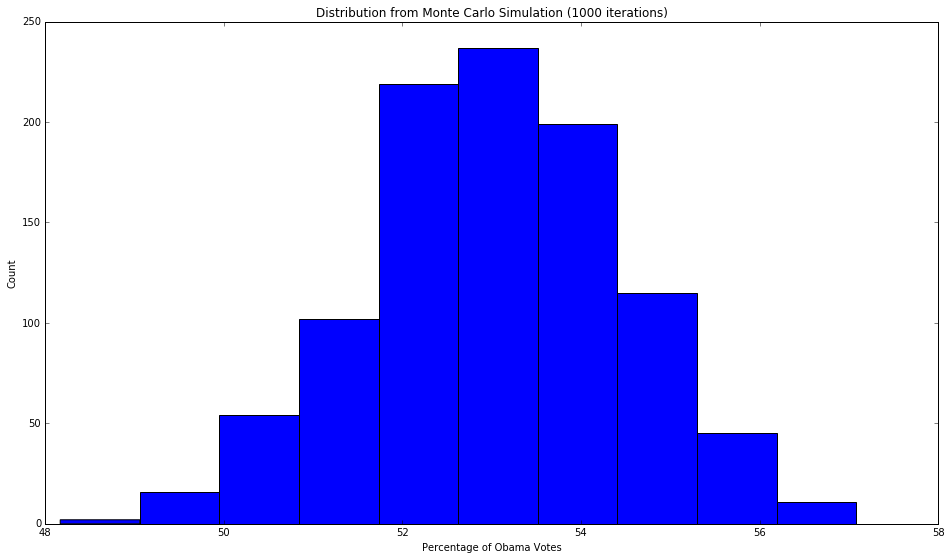

Mean: 53.04
std: 1.43


In [10]:
#your code here
plt.figure(figsize=(16,9))
percentObama = X/N*100
plt.hist(percentObama)
plt.xlabel("Percentage of Obama Votes")
plt.ylabel("Count")
plt.title("Distribution from Monte Carlo Simulation (1000 iterations)")
plt.show()
print("Mean: %.2f" % percentObama.mean())
print("std: %.2f" % percentObama.std())

Answer: It has a normal distribution between 49-57%. The mean is 53.03% and the standard deviation is 1.39%

What is the standard error (SE) of the estimated percentage from the poll. 

**Hint**: Remember the SE is the standard deviation (SD) of the distribution of a random variable. 

In [11]:
#your code here
print("std: %.2f" % percentObama.std())

std: 1.43


#### Problem 2(c)

Now suppose we run M polls where M is the number of polls that happened in November (calculated in Problem 2(a)). Run 1,000 simulations and compute the mean of the M polls for each simulation. 

In [12]:
#your code here
NovMeans = np.array([np.random.binomial(N,p,M).mean() for i in range(1000)])/N*100

What is the distribution of the average of polls?

**Hint**: Show a plot. 

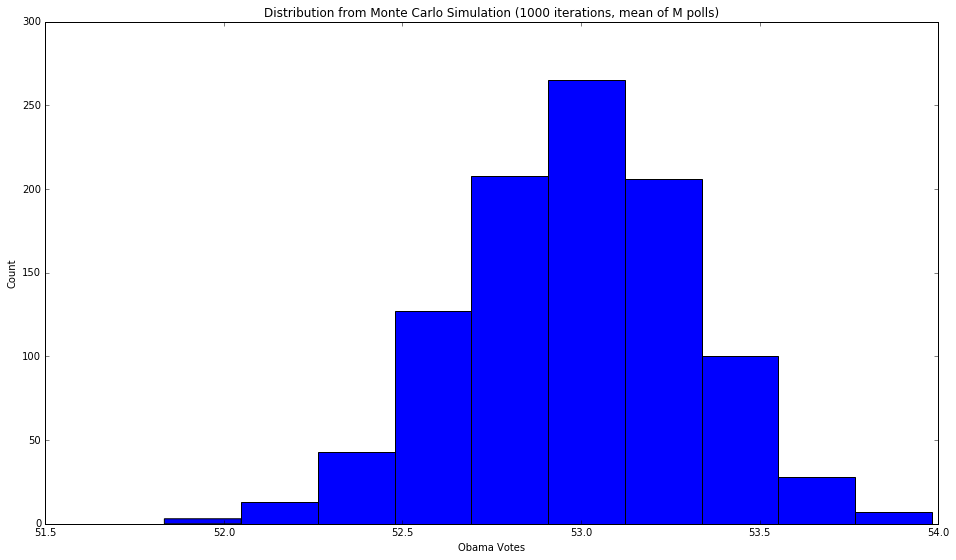

Mean: 52.98
std: 0.32


In [13]:
#your code here
plt.figure(figsize=(16,9))
plt.hist(NovMeans)
plt.xlabel("Obama Votes")
plt.ylabel("Count")
plt.title("Distribution from Monte Carlo Simulation (1000 iterations, mean of M polls)")
plt.show()
print("Mean: %.2f" % NovMeans.mean())
print("std: %.2f" % NovMeans.std())

Answer: It's still a normal distribution. The range is smaller. 52-54.25% with mean 52.99% and std 0.33%.

What is the standard error (SE) of the average of polls? 

In [14]:
#your code here
print("std: %.2f" % NovMeans.std())

std: 0.32


Answer: 0.33

Is the SE of the average of polls larger, the same, or smaller than that the SD of a single poll (calculated in Problem 2(b))? By how much?

**Hint**: Compute a ratio of the two quantities.  

In [15]:
#your code here
1 - NovMeans.std()/percentObama.std()

0.77327550942724221

Answer: The SE of the average polls is 76% smaller than the SE of a single poll.

#### Problem 2(d) 

Repeat Problem 2(c) but now record the *across poll* standard deviation in each simulation. 

In [16]:
#your code here
NovSTD = np.array([np.random.binomial(N,p,M).std() for i in range(1000)])/N*100

What is the distribution of the *across M polls* standard deviation?

**Hint**: Show a plot. 

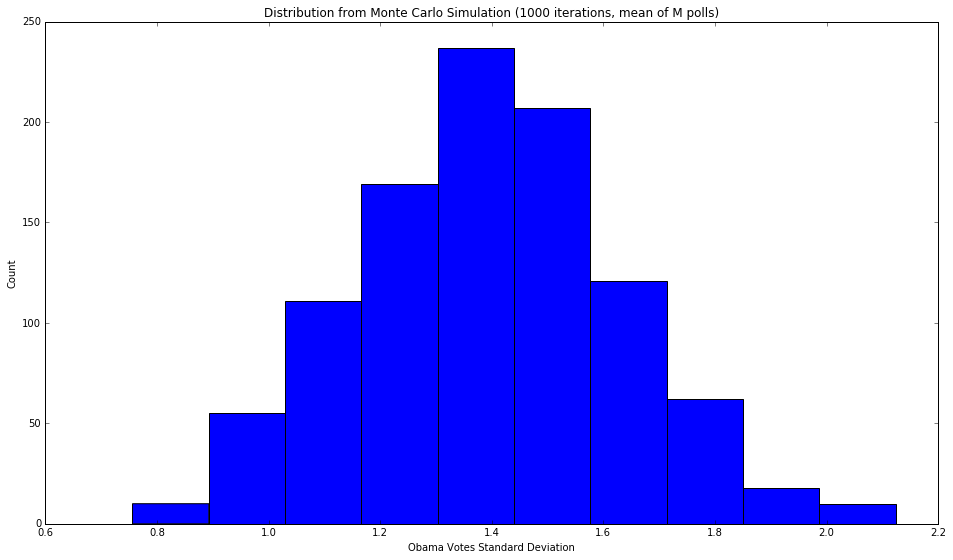

Mean: 1.39
std: 0.24


In [17]:
#your code here
plt.figure(figsize=(16,9))
plt.hist(NovSTD)
plt.xlabel("Obama Votes Standard Deviation")
plt.ylabel("Count")
plt.title("Distribution from Monte Carlo Simulation (1000 iterations, mean of M polls)")
plt.show()
print("Mean: %.2f" % NovSTD.mean())
print("std: %.2f" % NovSTD.std())

Answer: Another normal distribution. Range is 0.8-2.1, Mean is 1.39, STD is 0.22

#### Problem 2(e) 

What is the standard deviation of M polls in our real (not simulated) 2012 presidential election data ? 

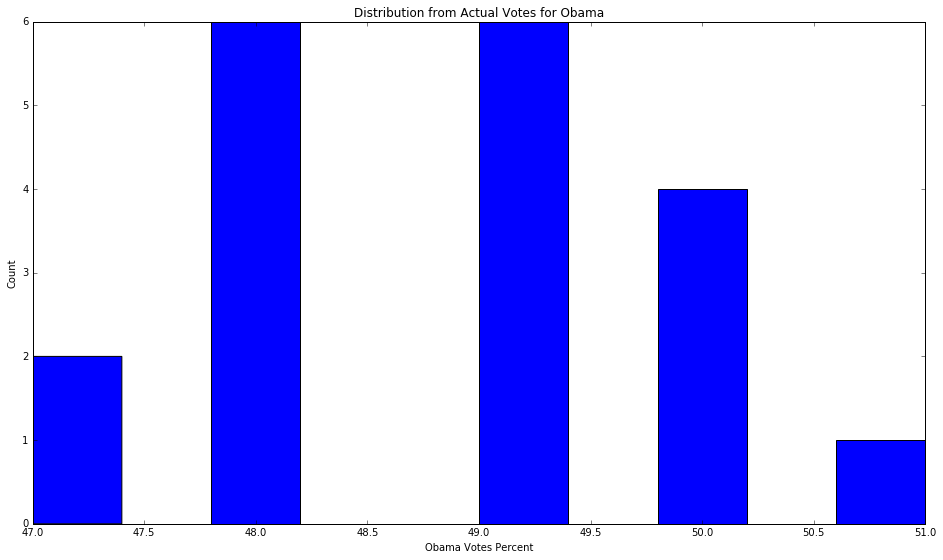

Mean: 48.79
std: 1.08


In [18]:
#your code here
plt.figure(figsize=(16,9))
plt.hist(NovPolls.Obama.values)
plt.xlabel("Obama Votes Percent")
plt.ylabel("Count")
plt.title("Distribution from Actual Votes for Obama")
plt.show()
print("Mean: %.2f" % NovPolls.Obama.mean())
print("std: %.2f" % NovPolls.Obama.std())

Is this larger, the same, or smaller than what we expeced if polls were not biased.

In [19]:
#your code here
NovSTD.mean()

1.392003780921953

Answer: The real standard deviation is less than the simulated on by .29%

#### Problem 2(f)

Learn about the normal approximation for the binomial distribution and derive the results of Problem 2(b) and 2(c) analytically (using this approximation). Compare the results obtained analytically to those obtained from simulations.

> https://www.youtube.com/watch?v=CCqWkJ_pqNU

In [20]:
from scipy.stats import norm

In [21]:
#your code here
print("p=%.2f\nn=%d" % (p,N))
print("pn=%.2f\nqn=%.2f" %(p*N, (1-p)*N))

p=0.53
n=1200
pn=636.00
qn=564.00


mean=636.00
std=17.29


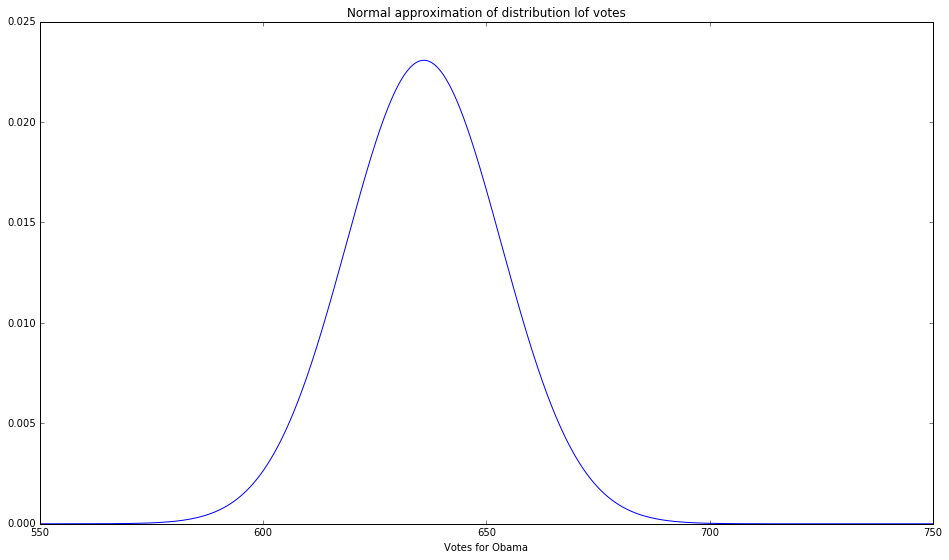

In [22]:
mean=p*N
var = N*p*(1-p)
std= np.sqrt(var)
Xvar0=np.arange(550, 750, 0.001)

plt.figure(figsize=(16,9))
plt.plot(Xvar0, norm.pdf(Xvar0,mean,std))
plt.xlabel("Votes for Obama")
plt.title("Normal approximation of distribution lof votes")

print("mean=%.2f\nstd=%.2f" % (mean,std))

mean=53.00%
std=4.99%


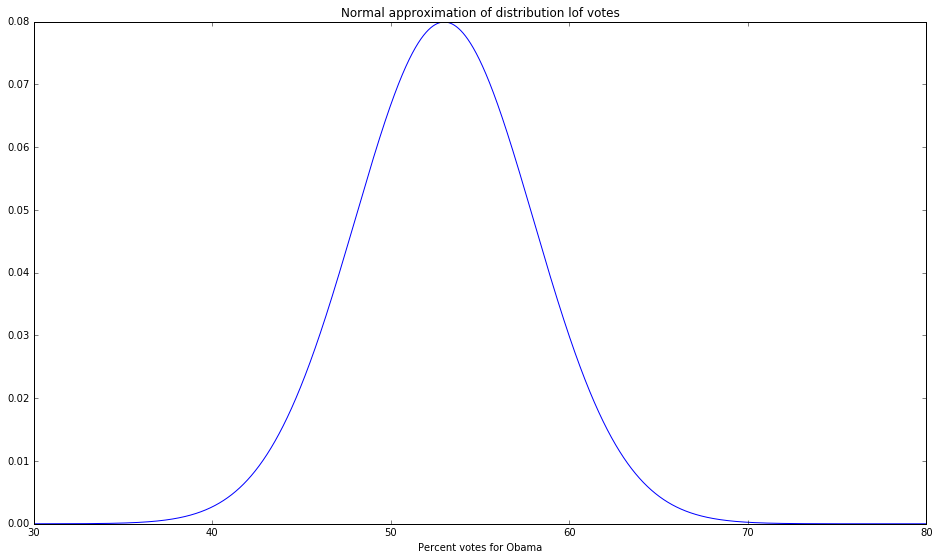

In [23]:
meanpercent=mean/N*100
stdpercent=std/np.sqrt(N)*10
Xvar1=np.arange(30, 80, 0.001)

plt.figure(figsize=(16,9))
plt.plot(Xvar1, norm.pdf(Xvar1,meanpercent,stdpercent))
plt.xlabel("Percent votes for Obama")
plt.title("Normal approximation of distribution lof votes")


print("mean=%.2f%%\nstd=%.2f%%" % (meanpercent,stdpercent))

> In our simulation we got more votes than through the approximation, but the approximation is very close. 664 votes versus 636 respectively. The mean percent votes in the simulation was 52.98% with a standard deviation of 1.43 while the approximation gave 53% with std 4.99. Let's do a Monte Carlo Simulation:

In [24]:
NovMeansApproximate = np.array([np.random.normal(mean,std,M).mean() for i in range(1000)])/N*100

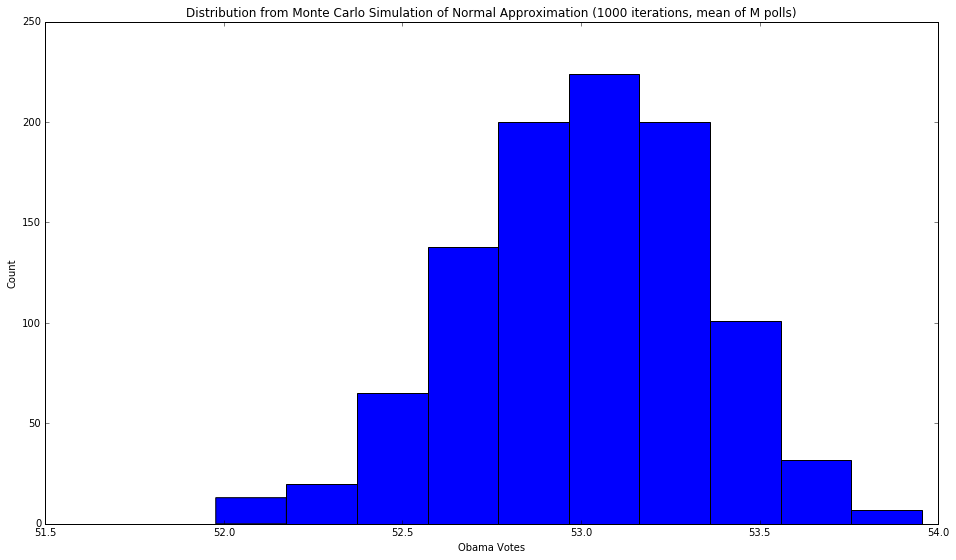

Mean: 53.01
std: 0.33


In [25]:
plt.figure(figsize=(16,9))
plt.hist(NovMeansApproximate)
plt.xlabel("Obama Votes")
plt.ylabel("Count")
plt.title("Distribution from Monte Carlo Simulation of Normal Approximation (1000 iterations, mean of M polls)")
plt.show()
print("Mean: %.2f" % NovMeansApproximate.mean())
print("std: %.2f" % NovMeansApproximate.std())

> The results are shockingly close. The histogram above was formed by taking M samples from the normal distribution with our mean and standard deviation and computing the mean of the samples 1000 times. The mean and standard deviation of this distribution are very close to what was obtained in 2(c). The mean here is greater by 0.01

## Discussion for Problem 2

*Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.*

---


> For this problem, I simulated the number of votes for Obama using a sample size of 1000. I used binomial distribution to grab the samples. Additionally, I looked at the distribution of the mean of 19 poll locations. Both of these simulations looked like a normal distribution, so for the last portion of the problem, I used normal approximation of the binomial distribution to simulate approximate results. The results were incredibly similar. Both the simulation and the approximation gave results that were different from the actual results, but they serve fairly well as a model.

# Submission Instructions

To submit your homework, create a folder named **lastname_firstinitial_hw#** and place your IPython notebooks, data files, and any other files in this folder. Your IPython Notebooks should be completely executed with the results visible in the notebook. We should not have to run any code. Make sure to share the private repo with my github account (mdog) and submit the repo path through blackboard.


In [26]:
election.to_csv("data/electionP2.csv")

In [27]:
election.head()

,Pollster,Start Date,End Date,Entry Date/Time (ET),Number of Observations,Population,Mode,Obama,Romney,Undecided,Other,Pollster URL,Source URL,Partisan,Affiliation,Question Text,Question Iteration
0,Politico/GWU/Battleground,2012-11-04,2012-11-05,2012-11-06T08:40:26Z,1000.0,Likely Voters,Live Phone,47.0,47.0,6.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.politico.com/news/stories/1112/8338...,Nonpartisan,None,NaN,1
1,YouGov/Economist,2012-11-03,2012-11-05,2012-11-26T15:31:23Z,740.0,Likely Voters,Internet,49.0,47.0,3.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://cdn.yougov.com/cumulus_uploads/document...,Nonpartisan,None,NaN,1
2,Gravis Marketing,2012-11-03,2012-11-05,2012-11-06T09:22:02Z,872.0,Likely Voters,Automated Phone,48.0,48.0,4.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.gravispolls.com/2012/11/gravis-mark...,Nonpartisan,None,NaN,1
3,IBD/TIPP,2012-11-03,2012-11-05,2012-11-06T08:51:48Z,712.0,Likely Voters,Live Phone,50.0,49.0,NaN,1.0,http://elections.huffingtonpost.com/pollster/p...,http://news.investors.com/special-report/50841...,Nonpartisan,None,NaN,1
4,Rasmussen,2012-11-03,2012-11-05,2012-11-06T08:47:50Z,1500.0,Likely Voters,Automated Phone,48.0,49.0,NaN,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.rasmussenreports.com/public_content...,Nonpartisan,None,NaN,1
